In [72]:
!pip install anthropic
!pip install openai

In [73]:
from google.colab import userdata
import anthropic
import base64
from io import BytesIO
from PIL import Image
import os
import json
from openai import OpenAI
import gradio as gr
import openai

In [74]:
api_key = userdata.get('ANTHROPIC_TOKEN')
client = anthropic.Anthropic(api_key=api_key)

api_key1 = userdata.get('OPENAI_TOKEN')
client1 = openai.OpenAI(api_key=api_key1)

In [75]:
def calculator(operation, operand1, operand2):
    if operation == "add":
        return operand1 + operand2
    elif operation == "subtract":
        return operand1 - operand2
    elif operation == "multiply":
        return operand1 * operand2
    elif operation == "divide":
        if operand2 == 0:
            raise ValueError("Cannot divide by zero.")
        return operand1 / operand2
    else:
        raise ValueError(f"Unsupported operation: {operation}")

In [76]:
calculator("add",10,3)

13

In [77]:
calculator_tool = {
    "name": "calculator",
    "description": "A simple calculator that performs basic arithmetic operations.",
    "input_schema": {
        "type": "object",
        "properties": {
            "operation": {
                "type": "string",
                "enum": ["add", "subtract", "multiply", "divide"],
                "description": "The arithmetic operation to perform."
            },
            "operand1": {
                "type": "number",
                "description": "The first operand."
            },
            "operand2": {
                "type": "number",
                "description": "The second operand."
            }
        },
        "required": ["operation", "operand1", "operand2"]
    }
}

In [78]:
def prompt_claude(prompt, history):
    messages = history + [{"role": "user", "content": prompt}]
    result = 0

    try:
        message = client.messages.create(
            model="claude-3-5-sonnet-20241022",
            max_tokens=1000,
            messages=messages,
            system="You have access to tools, but only use them when necessary. If a tool is not required, respond as normal. The result of calculation is given for Dalle for image processing",
            tools=[calculator_tool]
        )

        if message.stop_reason == "tool_use":
            tool_use = message.content[-1]
            tool_name = tool_use.name
            tool_input = tool_use.input

            if tool_name == "calculator":
                print("Claude wants to use the calculator tool")
                operation = tool_input["operation"]
                operand1 = tool_input["operand1"]
                operand2 = tool_input["operand2"]

                try:
                    result = calculator(operation, operand1, operand2)
                    print("Calculation result is:", result)

                    # Create tool response with correct tool_call_id
                    tool_response = {
                        "role": "tool",
                        "content": json.dumps({"operation": operation, "result": result}),
                        "tool_call_id": tool_use.id  # Fixed: use tool_use.id instead of tool_call.id
                    }

                    messages.append(tool_response)

                    # Get final response from Claude
                    final_message = client.messages.create(
                        model="claude-3-5-sonnet-20241022",
                        max_tokens=1000,
                        messages=messages,
                        system="You have access to tools, but only use them when necessary. If a tool is not required, respond as normal. The result of calculation is given for Dalle for image processing",
                        tools=[calculator_tool]
                    )

                    return final_message.content

                except ValueError as e:
                    print(f"Error: {str(e)}")
                    return [{"type": "text", "text": f"Calculator error: {str(e)}"}]

        elif message.stop_reason == "end_turn":
            print("Claude didn't want to use a tool")
            print("Claude responded with:")
            print(message.content[0].text)
            return message.content

        else:
            # Handle other stop reasons
            return message.content

    except Exception as e:
        print(f"❌ Setup failed: {e}")
        return [{"type": "text", "text": f"Error: {str(e)}"}]

In [79]:
message = prompt_claude("I had 53 chickens but 5 flew away.  How many are left?")
message

Claude wants to use the calculator tool
Calculation result is: 48


48

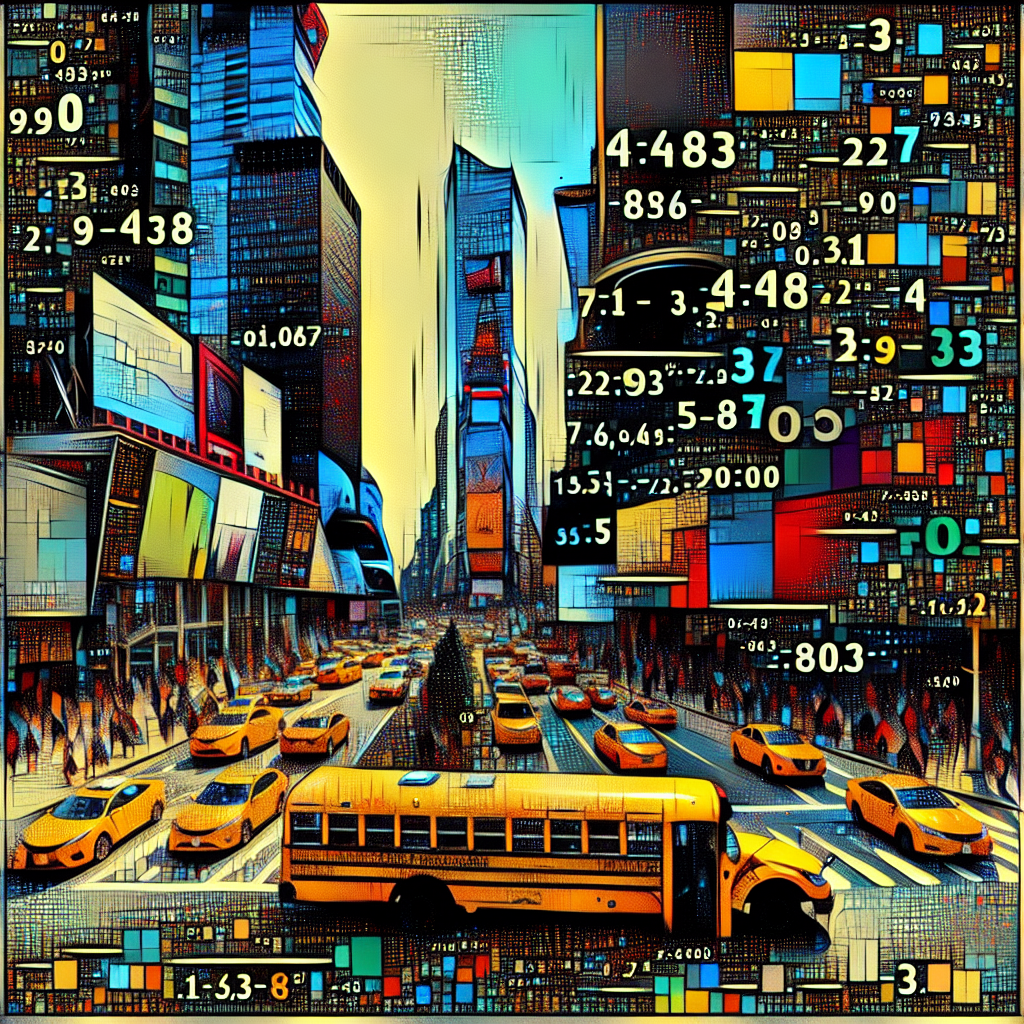

In [80]:
def generate_artist_openai(prompt):
    image_response = client1.images.generate(
            model="dall-e-3",
            prompt=f"An image representing the calculation described in the {prompt}, showing different operands, in a vibrant pop-art style",
            size="1024x1024",
            n=1,
            response_format="b64_json",
        )
    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

image = generate_artist_openai("New York City")
display(image)

In [81]:
def chat(prompt,history):
    response = prompt_claude(prompt)
    image = generate_artist_openai(prompt)

    messages = history + [{"role": "user", "content": response}]
    print(prompt)

    return prompt, image


In [82]:
prompt, image = chat("I had 100 chickens but 5 flew away.  How many are left?")

Claude wants to use the calculator tool
Calculation result is: 95


TypeError: can only concatenate str (not "list") to str

In [ ]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)